In [1]:
# The usual boilerplate
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Remotely Querying Astronomical Data: Astroquery

At this point we know what databases are, how to work with them, and how to query remote databases powering astronomical data archives using their web interfaces.

We'll now do this last bit directly from Python, using a module called `astroquery`.

## Astroquery

Astroquery is a set of tools for querying astronomical web forms and databases, from Python. It supports accessing a myriad of astronomical archives and services through an increasingly uniform interface.

Documentation: http://astroquery.readthedocs.io/en/latest/index.html

## Installing

Use Anaconda's `conda` package manager to download and install astroquery:

```
conda install -c astropy astroquery
```

The `-c astropy` tells conda to download astroquery from the `astropy` _channel_. Google for "conda channels" to learn more.

## Example: Astroquery-ing the SDSS

There's more than one way to query the SDSS catalogs using astroquery. Most common functions are:

* `query_region`: Query a region around given coordinates. 
* `query_photoobj`: Query the PhotoObjAll table with run, rerun, camcol and field values.
* `query_specobj`: Query the SpecObjAll table with plate, mjd and fiberID values.
* `query_sdss`: Run a general SQL query on the SDSS database.

Documentation:

* http://astroquery.readthedocs.io/en/latest/sdss/sdss.html
* http://astroquery.readthedocs.io/en/latest/api/astroquery.sdss.SDSSClass.html


Let's use the SQL query capability, to run one of the [SQL tutorial](http://cas.sdss.org/dr14/en/help/howto/search/searchhowtohome.aspx) queries:

In [2]:
from astroquery.sdss import SDSS

query = """
select top 5
    z, ra, dec, bestObjID
from specObj
where
    class = 'galaxy'
    and z > 0.3
    and zWarning = 0
"""

res = SDSS.query_sql(query)
res

/Users/ridder/anaconda3/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


z,ra,dec,bestObjID
float64,float64,float64,int64
0.3000005,174.54051,24.200028,1237667549812162759
0.3000012,49.459411,0.847754,1237660241924063461
0.3000027,156.25024,7.6586271,1237658425162858683
0.3000035,184.90501,-3.3095095,1237650760782053596
0.3000046,175.65125,34.37548,1237665128003731630


Now we'll try a more complex query, that will take a longer time to execute. This will require to change the `timeout` parameter (the default is to wait for 60 seconds).

In [3]:
query = """
SELECT
  s.ra, s.dec,
  s.dered_g as g, s.dered_r as r,
  s.err_g, s.err_r,
  s.flags
  
FROM
  dbo.fGetNearbyObjEq(341.6, 31.7, 60) AS n
  JOIN Star AS s ON n.objID = s.objID
  
WHERE
  g - r BETWEEN -0.5 AND 2.5
  AND g BETWEEN 14 and 24
"""

res = SDSS.query_sql(query, timeout=3600)
print(len(res))
res[:2]

55103


ra,dec,g,r,err_g,err_r,flags
float64,float64,float64,float64,float64,float64,int64
341.247844627077,32.2513831862674,21.69961,20.9814,0.08215322,0.05463045,68987912448
340.875068736191,31.8154203216862,23.28841,22.49326,0.250676,0.1693792,68987912448


Let's visualize what came back:

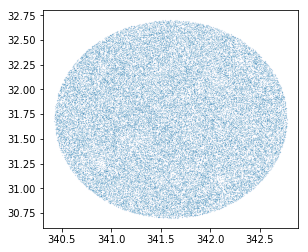

In [4]:
fig, ax = plt.subplots()
ax.scatter(res['ra'], res['dec'], marker='.', s=0.01)
ax.set_aspect('equal')

... and re-use the work from the other day:

In [5]:
import visutils
visutils.interactive_hess(res['g'], res['g']-res['r'])

interactive(children=(IntSlider(value=100, description='grd', max=300, min=50), Output()), _dom_classes=('widg…

Now for a different field (direction on the sky):

In [6]:
query = """
SELECT
  s.ra, s.dec,
  s.dered_g as g, s.dered_r as r,
  s.err_g, s.err_r,
  s.flags
  
FROM
  dbo.fGetNearbyObjEq(229.0128, -0.1082, 30) AS n
  JOIN Star AS s ON n.objID = s.objID
  
WHERE
  g - r BETWEEN -0.5 AND 2.5
  AND g BETWEEN 14 and 24
"""

res = SDSS.query_sql(query, timeout=3600)
print(len(res))
res[:2]

11989


ra,dec,g,r,err_g,err_r,flags
float64,float64,float64,float64,float64,float64,int64
229.013559888808,-0.108622393748343,20.6066,20.34597,0.0263483,0.02851533,35253393686544
229.012422394499,-0.110102518980999,19.73472,19.19518,0.01494448,0.01280767,35253393686544


In [7]:
visutils.interactive_hess(res['g'], res['g']-res['r'])

interactive(children=(IntSlider(value=100, description='grd', max=300, min=50), Output()), _dom_classes=('widg…

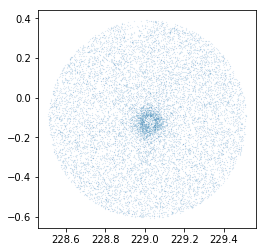

In [8]:
fig, ax = plt.subplots()
ax.scatter(res['ra'], res['dec'], marker='.', s=0.01)
ax.set_aspect('equal')

This is the globular cluster [Palomar 5](https://en.wikipedia.org/wiki/Palomar_5).

## A note about timeouts and limits

To be fair to other users, queries run from SkyServer search tools are restricted in how long they can run and how much output they return, by timeouts and row limits. See the [Query Limits help page](https://skyserver.sdss.org/dr14/en/help/docs/limits.aspx) to learn what these timeouts are. Queries taking longer than allowed cannot be executed through this interface; you have to use [CasJobs](http://skyserver.sdss.org/CasJobs/) instead (manually).

### Using the `query_region` method

In [9]:
from astropy import coordinates as coords

pos = coords.SkyCoord(229.0128, 50.1082, unit="deg")
res = SDSS.query_region(
    pos,
    radius="1 deg",
    fields=['ra', 'dec', 'dered_g', 'dered_r', 'err_g', 'err_r', 'flags']
)
print(len(res))
res[:2]

110139


ra,dec,dered_g,dered_r,err_g,err_r,flags
float64,float64,float64,float64,float64,float64,int64
228.013360912278,49.5164816575062,22.62085,21.79249,0.1439207,0.1056004,68987912192
228.013942675948,50.4357589619816,23.74485,22.17988,0.3770257,0.1334277,281543964623104


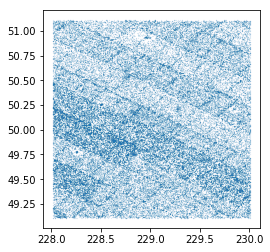

In [10]:
fig, ax = plt.subplots()
ax.scatter(res['ra'], res['dec'], marker='.', s=0.01)
ax.set_aspect('equal')

Lesson learned: don't trust everything you read in the documentation; test things yourselves!

## Building queries to access the original data
We can also extract the spectra (or images) from the SDSS catalog queries

In [11]:
pos = coords.SkyCoord(130.0128, -0.1082, unit="deg", frame='icrs')
res = SDSS.query_region(pos, radius="0.1 deg", spectro=True, timeout=3600)
print (res[:5])
sp = SDSS.get_spectra(matches=res, cache=False)

       ra                dec                objid        ... run2d  instrument
---------------- ------------------- ------------------- ... ------ ----------
130.098437847909  -0.157911970030089 1237648721208869381 ... v5_7_0       BOSS
130.063330843735  -0.177699574162535 1237648721208869227 ... v5_7_0       BOSS
130.013918974185 -0.0674448491699549 1237648721208869149 ... v5_7_0       BOSS
129.982715769615  -0.185047000779576 1237648721208804678 ... v5_7_0       BOSS
129.992910195779 -0.0685067679725222 1237648721208869539 ... v5_7_0       BOSS


/Users/ridder/anaconda3/lib/python3.6/site-packages/astroquery/sdss/core.py:857: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


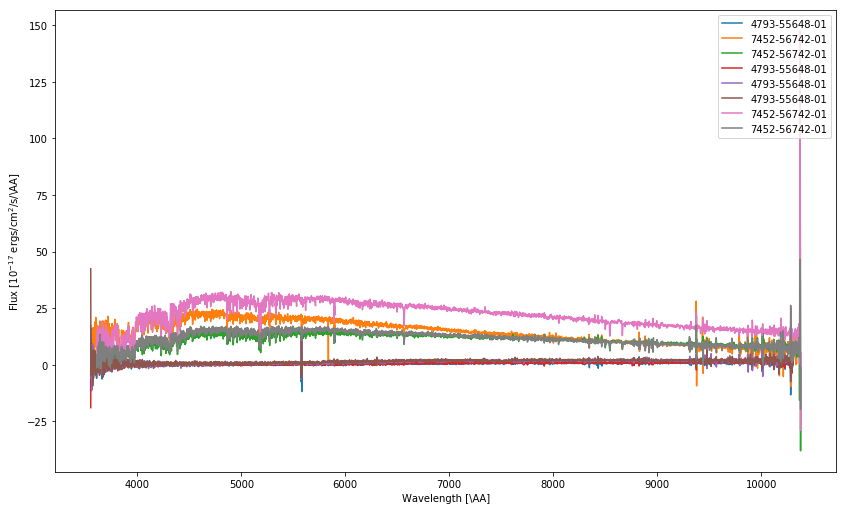

In [12]:
fig, ax = plt.subplots(figsize=(14.,8.5))
for spec in sp:
    ax.plot(10.**spec[1].data['loglam'],spec[1].data['flux'], label=spec[0].header['NAME'])
ax.set_ylabel('Flux [10$^{-17}$ ergs/cm$^2$/s/\AA]')
ax.set_xlabel('Wavelength [\AA]')
ax.legend(loc='upper right')

## Exercise: Query, download, and display an image from SDSS. For a bonus point create a color image from the downloaded images

## Astroquery: more than just points ##

(based on https://github.com/ESO-python/ESOPythonTutorials)

[Astroquery](http://astroquery.readthedocs.org) is a set of related tools for querying different astronomical database services,  e.g. SIMBAD, VizieR, and IRSA-IPAC, and for retrieving data from archives, e.g. the ESO, IRSA, and NRAO archives.  It also includes tools for querying other astronomy-related databases such as line-list servers at NIST (primarily for optical/NIR electronic transitions) and Splatalogue for mm/radio molecular transitions.

## Lets use Astroquery to search for high redshift QSOs (z>4.5) by selecting star like sources from the SDSS

Usually we use a mix of infrared and optical colors to find high redshift QSOs
- Given a region on the sky find all star-like sources in the SDSS within 10 arcmins of 00h07m49.17, +00d41m19.61s 
- Cross match the data against the WISE infrared catalog (the name of this catalog is "vizier:ii/328/allwise")
- Select QSOs as star-like sources with z-W1 > 2.5 and W1 - W2 >0.4
- Plot the stars and high redshift QSO candidates
- Match your QSOs with the "The Million Quasars (Milliquas) catalog" catalog of  QSOs and see if you found any

## Examples: SIMBAD general query

SIMBAD is the acronym for **S**et of **I**dentifications, **M**easurements and **B**ibliography for **A**stronomical **D**ata. The SIMBAD database is managed by the Centre de Données astronomiques de Strasbourg (CDS), France.

SIMBAD supports queries by source name (`query_object`) and by region (`query_region`).  The returned values are (almost) always [astropy tables](docs.astropy.org/en/latest/tables/).

In [54]:
from astroquery.simbad import Simbad
from astropy import coordinates
from astropy import units as u

Querying an object by name:

In [55]:
result1 = Simbad.query_object('M 31')
result1

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
M 31,00 42 44.330,+41 16 07.50,7,7,--,--,0,C,I,2006AJ....131.1163S


Querying by position:

In [56]:
result2 = Simbad.query_region("05h35m17.3s -05d23m28s", radius=1*u.arcmin)
result2[:5]

/Users/ridder/anaconda3/lib/python3.6/site-packages/astroquery/utils/commons.py:162: UserWarning: Coordinate string is being interpreted as an ICRS coordinate.
  warnings.warn("Coordinate string is being interpreted as an "


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
M 42,05 35 17.3,-05 23 28,5,5,7500.000,7500.000,90,D,,1981MNRAS.194..693L
NAME Ori Region,05 35 17.30,-05 23 28.0,6,6,--,--,0,D,O,
[OW94] 172-327,05 35 17.2210,-05 23 26.542,9,9,--,--,0,C,R,2016ApJ...822...93F
DOH 7 175-328,05 35 17.5,-05 23 28,5,5,--,--,0,D,,2004AJ....127.3456D
MAX 126,05 35 17.11,-05 23 29.3,6,6,--,--,0,D,I,2005AJ....129.1534R


Better:

In [57]:
co = coordinates.SkyCoord(l=31.0087, b=14.0627,
                          unit=(u.deg, u.deg),
                          frame='galactic')
print (co)
result3 = Simbad.query_region(co)
result3

<SkyCoord (Galactic): (l, b) in deg
    (31.0087, 14.0627)>


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
NAME Barnard's star,17 57 48.4997,+04 41 36.111,14,14,0.223,0.304,90,A,O,2018yCat.1345....0G
TYC 425-262-1,17 57 51.9500,+04 42 20.199,14,14,0.041,0.054,90,A,O,2018yCat.1345....0G
1RXS J175749.5+043955,17 57 49.505,+04 39 55.01,7,7,--,--,0,E,,2000IAUC.7432R...1V


### SIMBAD: Querying named catalogs

There are also other query tools for some services, e.g. SIMBAD has a `query_catalog` feature that allows you to query named catalogs, e.g. the NGC catalog or the ESO catalog

In [17]:
Simbad.query_catalog?

In [58]:
Simbad.ROW_LIMIT = 10
esocat = Simbad.query_catalog('eso')
esocat

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
2MASS J08300740-4325465,08 30 07.41,-43 25 46.6,6,6,60.000,60.000,90,C,I,2003yCat.2246....0C
NGC 2573,01 41 38.0117,-89 20 04.266,14,14,0.035,0.032,90,A,O,2018yCat.1345....0G
ESO 1-2,05 04 36.8,-87 34 19,5,5,8000.000,8000.000,90,D,,1982ESO...C......0L
ESO 1-3,05 22 36.509,-87 50 50.02,7,7,--,--,0,C,I,2006AJ....131.1163S
ESO 1-4,07 49 28.8195,-87 56 00.293,14,14,1.913,3.141,90,C,O,2018yCat.1345....0G
ESO 1-5,08 53 05.006,-88 05 23.00,7,7,--,--,0,C,I,2006AJ....131.1163S
ESO 1-6,14 27 19.4897,-87 46 19.985,14,14,1.582,1.150,90,C,O,2018yCat.1345....0G
ESO 1-7,17 02 45.879,-88 55 01.94,7,7,--,--,0,C,I,2006AJ....131.1163S


In [59]:

ngccat = Simbad.query_catalog('ngc')
ngccat

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
NGC 1,00 07 15.8554,+27 42 29.024,14,14,3.580,3.437,90,C,O,2018yCat.1345....0G
NGC 2,00 07 17.1152,+27 40 42.032,14,14,2.978,2.498,90,C,O,2018yCat.1345....0G
NGC 3,00 07 16.804,+08 18 05.84,7,7,--,--,0,C,I,2006AJ....131.1163S
NGC 4,00 07 24.4,+08 22 30,5,5,--,--,0,D,O,2003A&A...412...45P
NGC 5,00 07 48.898,+35 21 44.46,7,7,--,--,0,C,I,2006AJ....131.1163S
NGC 7,00 08 20.3,-29 55 01,5,5,--,--,0,D,O,2003A&A...412...45P
NGC 8,00 08 45.3,+23 50 19,5,5,--,--,0,D,O,2003A&A...412...45P
NGC 9,00 08 54.713,+23 49 00.92,7,7,--,--,0,C,I,2006AJ....131.1163S


### Querying sources from publications

In SIMBAD, you can also query a publication to find the sources

In [60]:
newberg2002 = Simbad.query_bibobj('2002ApJ...569..245N')
newberg2002

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object
M 31,00 42 44.330,+41 16 07.50,7,7,--,--,0,C,I,2006AJ....131.1163S
[NYR2002] S167-54-21.5,02 28,+00.0,2,2,--,--,0,E,,
[NYR2002] S200-24-19.8,05 03,+00.0,2,2,--,--,0,E,,
[NYR2002] S183+22-19.4,07 26,+36.0,2,2,--,--,0,E,,
[NYR2002] S218+22-19.5,08 19,+06.0,2,2,--,--,0,E,,
[NYR2002] S223+20-19.4,08 21,+01.0,2,2,--,--,0,E,,
[NYR2002] S297+63-20.5,12 41,+00.0,2,2,--,--,0,E,,
[NYR2002] S006+41-20.0,14 01,+08.0,2,2,--,--,0,E,,


Finally, you can modify the default parameters of the query tool, such as the `TIMEOUT` (the maximum wait time before deciding the query has failed) and the `ROW_LIMIT` (the maximum number of entries returned) by creating a new object.  You can also tell SIMBAD to return additional information, e.g. the number of citations for each object.

In [61]:
customSimbad = Simbad()
customSimbad.ROW_LIMIT = 100
customSimbad.add_votable_fields('bibcodelist(1800-2014)')
#customSimbad.list_votable_fields()
# bibcodelist(date1-date2) lists the number of bibliography
# items referring to each object over that date range
newberg2002 = customSimbad.query_bibobj('2002ApJ...569..245N')
newberg2002

MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,BIBLIST_1800_2014
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,int32
M 31,00 42 44.330,+41 16 07.50,7,7,--,--,0,C,I,2006AJ....131.1163S,8389
[NYR2002] S167-54-21.5,02 28,+00.0,2,2,--,--,0,E,,,8
[NYR2002] S200-24-19.8,05 03,+00.0,2,2,--,--,0,E,,,4
[NYR2002] S183+22-19.4,07 26,+36.0,2,2,--,--,0,E,,,3
[NYR2002] S218+22-19.5,08 19,+06.0,2,2,--,--,0,E,,,3
[NYR2002] S223+20-19.4,08 21,+01.0,2,2,--,--,0,E,,,6
[NYR2002] S297+63-20.5,12 41,+00.0,2,2,--,--,0,E,,,14
[NYR2002] S006+41-20.0,14 01,+08.0,2,2,--,--,0,E,,,2


## More than just catalogs
There are archive query services that return images, spectra, instrument information, and metadata in addition to catalogs.

### Example: ESO archive

The ESO service has the following methods:

 * `list_instruments` to list the available instruments that can be queried
 * `list_surveys` lists the available large public surveys
 * `query_instrument` queries for data sets from a specific instrument
 * `query_surveys` does the same for surveys
 * `get_headers` gets header information for any datasets listed from a previous query
 * `login` logs you in with your username, which is *required* for *any* data retrieval (even public data)
 * `retrieve_datasets` or (deprecated) `data_retrieval` allows you to stage *and* download any data set your username is allowed to access
 
Queries are cached, so repeating them should be fast.  Downloaded data is also cached to the `Eso.cache_location`

In [62]:
from astroquery.eso import Eso

Eso.list_instruments()

['fors1',
 'fors2',
 'sphere',
 'vimos',
 'omegacam',
 'hawki',
 'isaac',
 'naco',
 'visir',
 'vircam',
 'apex',
 'giraffe',
 'uves',
 'xshooter',
 'espresso',
 'muse',
 'crires',
 'kmos',
 'sinfoni',
 'amber',
 'gravity',
 'midi',
 'pionier',
 'wlgsu',
 'harps',
 'feros']

In order to figure out how to construct a query, you can open the form directly

In [63]:
Eso.query_instrument('kmos', open_form=True)

or use the ``help`` keyword.  The printout will then show what keywords correspond to each form name.  For example, the keyword ``pi_coi`` corresponds to the form box ``PI/CoI Name``.

In [24]:
Eso.query_instrument('kmos', help=True)

INFO: List of the column_filters parameters accepted by the kmos instrument query. [astroquery.eso.core]
INFO: The presence of a column in the result table can be controlled if prefixed with a [ ] checkbox. [astroquery.eso.core]
INFO: The default columns in the result table are shown as already ticked: [x]. [astroquery.eso.core]

Target Information
------------------
    target: 
    resolver: simbad (SIMBAD name), ned (NED name), none (OBJECT as specified by the observer)
    coord_sys: eq (Equatorial (FK5)), gal (Galactic)
    coord1: 
    coord2: 
    box: 
    format: sexagesimal (Sexagesimal), decimal (Decimal)
[x] wdb_input_file: 

Observation and proposal parameters
-----------------------------------
[ ] night: 
    stime: 
    starttime: 00 (00 hrs [UT]), 01 (01 hrs [UT]), 02 (02 hrs [UT]), 03 (03 hrs [UT]), 04 (04 hrs [UT]), 05 (05 hrs [UT]), 06 (06 hrs [UT]), 07 (07 hrs [UT]), 08 (08 hrs [UT]), 09 (09 hrs [UT]), 10 (10 hrs [UT]), 11 (11 hrs [UT]), 12 (12 hrs [UT]), 13 (13 hr

In [66]:
result = Eso.query_instrument('xshooter', pi_coi='manara')
result

Release Date,Object,RA,DEC,Target Ra Dec,Target l b,ProgId,DP.ID,OB.ID,OBS.TARG.NAME,EXPTIME,DPR.CATG,DPR.TYPE,DPR.TECH,INS MODE,SEQ.ARM,DET.READ.CLOCK,INS.FILT1.NAME,INS.OPTI2.NAME,INS.OPTI3.NAME,INS.OPTI4.NAME,INS.OPTI5.NAME,DIMM Seeing-avg
str10,str8,float64,float64,str23,str21,str13,str29,int64,str22,float64,str11,str8,str20,str8,str3,str20,str1,str4,str7,str7,str7,str11
2016-01-28,"LAMP,AFC",167.009583,-76.67619,11:08:02.30 -76:40:34.3,296.960415 -15.018610,096.C-0979(A),XSHOO.2016-01-28T05:58:34.628,1261417,LM717,2.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,NIR,--,--,SLOT,Pin_0.5,Pin_0.5,Pin_0.5,0.90 [0.01]
2016-01-28,"LAMP,AFC",167.009583,-76.67619,11:08:02.30 -76:40:34.3,296.960415 -15.018610,096.C-0979(A),XSHOO.2016-01-28T05:59:04.026,1261417,LM717,1.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,VIS,400k/1pt/lg/AFC,--,PIN,5.0x11,5.0x11,5.0x11,0.90 [0.01]
2016-01-28,OBJECT,167.010573,-76.67625,11:08:02.54 -76:40:34.5,296.960657 -15.018573,096.C-0979(A),XSHOO.2016-01-28T06:02:27.308,1261417,LM717,15.0,ACQUISITION,OBJECT,IMAGE,IMAG,AGC,acetecE2V57I_ENG.clk,V,MIR,5.0x11,5.0x11,5.0x11,0.93 [0.01]
2016-01-28,"LAMP,AFC",167.009583,-76.67619,11:08:02.30 -76:40:34.3,296.960415 -15.018610,096.C-0979(A),XSHOO.2016-01-28T05:59:03.842,1261417,LM717,2.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,NIR,--,--,PIN,5.0x11,5.0x11,5.0x11,0.90 [0.01]
2016-01-28,"LAMP,AFC",241.460833,-25.55378,16:05:50.60 -25:33:13.6,348.826268 19.528763,096.C-0979(A),XSHOO.2016-01-28T09:03:47.852,1261387,PZ99J160550.5-2533,5.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,UVB,400k/1pt/lg/AFC,--,SLOT,Pin_0.5,Pin_0.5,Pin_0.5,1.30 [0.63]
2016-01-28,"LAMP,AFC",241.460833,-25.55378,16:05:50.60 -25:33:13.6,348.826268 19.528763,096.C-0979(A),XSHOO.2016-01-28T09:04:17.059,1261387,PZ99J160550.5-2533,1.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,VIS,400k/1pt/lg/AFC,--,PIN,5.0x11,5.0x11,5.0x11,1.30 [0.63]
2017-08-08,OBJECT,241.072175,-19.70769,16:04:17.32 -19:42:27.7,353.067645 23.863089,097.C-0378(A),XSHOO.2016-08-07T23:52:45.367,1318219,2MASSJ16041740-1942287,4.0,ACQUISITION,OBJECT,IMAGE,IMAG,AGC,acetecE2V57I_ENG.clk,V,MIR,5.0x11,5.0x11,5.0x11,0.99 [0.01]
2016-08-07,"LAMP,AFC",241.072496,-19.70797,16:04:17.40 -19:42:28.7,353.067650 23.862677,097.C-0378(A),XSHOO.2016-08-07T23:48:34.309,1318219,2MASSJ16041740-1942287,5.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,UVB,400k/1pt/lg/AFC,--,SLOT,Pin_0.5,Pin_0.5,Pin_0.5,N/A
2016-08-07,"LAMP,AFC",241.072496,-19.70797,16:04:17.40 -19:42:28.7,353.067650 23.862677,097.C-0378(A),XSHOO.2016-08-07T23:48:35.117,1318219,2MASSJ16041740-1942287,2.0,CALIB,"LAMP,AFC",ECHELLE,CALIB,NIR,--,--,SLOT,Pin_0.5,Pin_0.5,Pin_0.5,N/A


How do I get a unique list of programs that contained these observations?

A simple python trick: a ``set`` is an unordered collection of unique objects (just like in math).  ``np.unique`` does the same thing, but returns a numpy array, which is ordered.

In [68]:
result['ProgId']
np.unique(result['ProgId'])

096.C-0979(A)
097.C-0378(A)
288.C-5038(A)


In [69]:
set(result['ProgId'])

{'096.C-0979(A)', '097.C-0378(A)', '288.C-5038(A)'}

## Vizier ## 
Vizier is one of the main repositories of published catalogs (especially small ones).  It provides some very powerful interfaces including an x-match (cross-matching) service.  

In [70]:
from astroquery.vizier import Vizier

A particularly useful example - search for guide stars within a set radius of your target sources.

The guide star catalog, ``II/246``, is queried with the restriction that the guide star must have $M_K<9$ around the selected object, given that the distance between the guide star and the object is $2" < r < 30"$.

In [71]:
agn = coordinates.SkyCoord(l=131.0087 * u.deg, b=40.23 * u.deg, frame='galactic')
guide = Vizier(catalog="gsc", column_filters={"Kmag":"<9.0"}).query_region(agn, radius="30s", inner_radius="2s")[0]
guide

APM-ID,RAJ2000,DEJ2000,rmag,l_rmag,rClass,rStel,rDiam,rEll,bmag,l_bmag,bClass,bStel,bDiam,b-r,Mflag
,deg,deg,mag,,,,arcsec,,mag,,,,arcsec,mag,
bytes14,float64,float64,float32,bytes1,int16,float64,float64,float64,float32,bytes1,int16,float64,float64,float64,bytes1
EO1326-0251283,167.850995,75.294142,20.00,L,0,--,--,--,21.73,,-1,-0.53,3.6,1.73,
EO1326-0251425,167.855312,75.290945,19.95,,1,7.01,5.3,0.73,22.01,L,0,--,--,2.06,


In [72]:
### Cone Search services
from astropy.coordinates import SkyCoord
from astroquery.vo_conesearch import ConeSearch
ConeSearch.URL

c = SkyCoord.from_name('M31')
c.ra, c.dec

result = ConeSearch.query_region(c, '0.1 deg')
result

<Table masked=True length=4028>
    objID           gsc2ID      gsc1ID ... multipleFlag compassGSC2id   Mag  
                                       ...                              mag  
    int64           object      object ...    int32         int64     float32
-------------- ---------------- ------ ... ------------ ------------- -------
23323175812944 00424433+4116085        ...            0 6453800072293   9.453
23323175812948 00424403+4116069        ...            0 6453800072297   9.321
23323175812933 00424455+4116103        ...            0 6453800072282  10.773
23323175812939 00424464+4116092        ...            0 6453800072288   9.299
23323175812930 00424403+4116108        ...            0 6453800072279  11.507
23323175812931 00424464+4116106        ...            0 6453800072280   9.399
23323175812973 00424446+4116016        ...            0 6453800072322   12.07
23323175812966 00424398+4116028        ...            0 6453800072315  12.136
23323175812979 00424420+4116009 

Annoyingly, this module does _not_ return an `astropy.table` Table object, so we have to create one:

In [73]:
from astropy.table import Table
Table(result.array)[:3]

objID,gsc2ID,gsc1ID,hstID,ra,dec,epoch,raEpsilon,decEpsilon,rapm,decpm,rapmErr,decpmErr,deltaEpoch,FpgMag,FpgMagErr,FpgMagCode,JpgMag,JpgMagErr,JpgMagCode,NpgMag,NpgMagErr,NpgMagCode,UMag,UMagErr,UMagCode,BMag,BMagErr,BMagCode,VMag,VMagErr,VMagCode,RMag,RMagErr,RMagCode,IMag,IMagErr,IMagCode,JMag,JMagErr,JMagCode,HMag,HMagErr,HMagCode,KMag,KMagErr,KMagCode,class,semiMajorAxis,eccentricity,positionAngle,sourceStatus,variableFlag,multipleFlag,compassGSC2id,Mag
int64,object,object,object,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,int32,float32,float32,float32,int64,int32,int32,int64,float32
23323175812944,00424433+4116085,,2MJG1R2O,10.684737,41.269035,1997.815,0.08,0.07,0.0,0.0,0.0,0.0,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,9.453,0.052,47,8.668,0.051,48,8.475,0.051,49,4,0.0,0.0,0.0,77777700,0,0,6453800072293,9.453
23323175812948,00424403+4116069,,2MJG1R2S,10.683469,41.268585,1997.815,0.13,0.12,0.0,0.0,0.0,0.0,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,9.321,-999.0,47,8.614,-999.0,48,10.601,0.025,49,4,0.0,0.0,0.0,77777700,0,0,6453800072297,9.321
23323175812933,00424455+4116103,,2MJG1R2D,10.685657,41.26955,1997.815,0.13,0.12,0.0,0.0,0.0,0.0,0.0,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,99.99,99.99,99,10.773,0.069,47,8.532,-999.0,48,8.254,-999.0,49,4,0.0,0.0,0.0,77777700,0,0,6453800072282,10.773


Getting a list of catalogs that are available through the cone search service:

In [74]:
from astroquery.vo_conesearch import conesearch
conesearch.list_catalogs()

['Guide Star Catalog 2.3 Cone Search 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 1',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 2',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 3',
 'SDSS DR7 - Sloan Digital Sky Survey Data Release 7 4',
 'SDSS DR8 - Sloan Digital Sky Survey Data Release 8 1',
 'SDSS DR8 - Sloan Digital Sky Survey Data Release 8 2',
 'The HST Guide Star Catalog, Version 1.1 (Lasker+ 1992) 1',
 'The HST Guide Star Catalog, Version 1.2 (Lasker+ 1996) 1',
 'The HST Guide Star Catalog, Version GSC-ACT (Lasker+ 1996-99) 1',
 'The USNO-A2.0 Catalogue (Monet+ 1998) 1',
 'Two Micron All Sky Survey (2MASS) 1',
 'Two Micron All Sky Survey (2MASS) 2']

In [76]:
from astropy import units as u
my_catname = 'Two Micron All Sky Survey (2MASS) 2'
result = conesearch.conesearch(c, 0.1 * u.degree, catalog_db=my_catname)
Table(result.array)[:5]

Trying http://wfaudata.roe.ac.uk/twomass-dsa/DirectCone?DSACAT=TWOMASS&DSATAB=twomass_xsc&


cx,cy,cz,htmID,jdate,designation,ra,dec,sup_ra,sup_dec,glon,glat,density,r_k20fe,j_m_k20fe,j_msig_k20fe,j_flg_k20fe,h_m_k20fe,h_msig_k20fe,h_flg_k20fe,k_m_k20fe,k_msig_k20fe,k_flg_k20fe,r_3sig,j_ba,j_phi,h_ba,h_phi,k_ba,k_phi,sup_r_3sig,sup_ba,sup_phi,r_fe,j_m_fe,j_msig_fe,j_flg_fe,h_m_fe,h_msig_fe,h_flg_fe,k_m_fe,k_msig_fe,k_flg_fe,r_ext,j_m_ext,j_msig_ext,j_pchi,h_m_ext,h_msig_ext,h_pchi,k_m_ext,k_msig_ext,k_pchi,j_r_eff,j_mnsurfb_eff,h_r_eff,h_mnsurfb_eff,k_r_eff,k_mnsurfb_eff,j_con_indx,h_con_indx,k_con_indx,j_peak,h_peak,k_peak,j_5surf,h_5surf,k_5surf,e_score,g_score,vc,cc_flg,im_nx,r_k20fc,j_m_k20fc,j_msig_k20fc,j_flg_k20fc,h_m_k20fc,h_msig_k20fc,h_flg_k20fc,k_m_k20fc,k_msig_k20fc,k_flg_k20fc,j_r_e,j_m_e,j_msig_e,j_flg_e,h_r_e,h_m_e,h_msig_e,h_flg_e,k_r_e,k_m_e,k_msig_e,k_flg_e,j_r_c,j_m_c,j_msig_c,j_flg_c,h_r_c,h_m_c,h_msig_c,h_flg_c,k_r_c,k_m_c,k_msig_c,k_flg_c,r_fc,j_m_fc,j_msig_fc,j_flg_fc,h_m_fc,h_msig_fc,h_flg_fc,k_m_fc,k_msig_fc,k_flg_fc,j_r_i20e,j_m_i20e,j_msig_i20e,j_flg_i20e,h_r_i20e,h_m_i20e,h_msig_i20e,h_flg_i20e,k_r_i20e,k_m_i20e,k_msig_i20e,k_flg_i20e,j_r_i20c,j_m_i20c,j_msig_i20c,j_flg_i20c,h_r_i20c,h_m_i20c,h_msig_i20c,h_flg_i20c,k_r_i20c,k_m_i20c,k_msig_i20c,k_flg_i20c,j_r_i21e,j_m_i21e,j_msig_i21e,j_flg_i21e,h_r_i21e,h_m_i21e,h_msig_i21e,h_flg_i21e,k_r_i21e,k_m_i21e,k_msig_i21e,k_flg_i21e,r_j21fe,j_m_j21fe,j_msig_j21fe,j_flg_j21fe,h_m_j21fe,h_msig_j21fe,h_flg_j21fe,k_m_j21fe,k_msig_j21fe,k_flg_j21fe,j_r_i21c,j_m_i21c,j_msig_i21c,j_flg_i21c,h_r_i21c,h_m_i21c,h_msig_i21c,h_flg_i21c,k_r_i21c,k_m_i21c,k_msig_i21c,k_flg_i21c,r_j21fc,j_m_j21fc,j_msig_j21fc,j_flg_j21fc,h_m_j21fc,h_msig_j21fc,h_flg_j21fc,k_m_j21fc,k_msig_j21fc,k_flg_j21fc,j_m_5,j_msig_5,j_flg_5,h_m_5,h_msig_5,h_flg_5,k_m_5,k_msig_5,k_flg_5,j_m_7,j_msig_7,j_flg_7,h_m_7,h_msig_7,h_flg_7,k_m_7,k_msig_7,k_flg_7,j_m_10,j_msig_10,j_flg_10,h_m_10,h_msig_10,h_flg_10,k_m_10,k_msig_10,k_flg_10,j_m_15,j_msig_15,j_flg_15,h_m_15,h_msig_15,h_flg_15,k_m_15,k_msig_15,k_flg_15,j_m_20,j_msig_20,j_flg_20,h_m_20,h_msig_20,h_flg_20,k_m_20,k_msig_20,k_flg_20,j_m_25,j_msig_25,j_flg_25,h_m_25,h_msig_25,h_flg_25,k_m_25,k_msig_25,k_flg_25,j_m_30,j_msig_30,j_flg_30,h_m_30,h_msig_30,h_flg_30,k_m_30,k_msig_30,k_flg_30,j_m_40,j_msig_40,j_flg_40,h_m_40,h_msig_40,h_flg_40,k_m_40,k_msig_40,k_flg_40,j_m_50,j_msig_50,j_flg_50,h_m_50,h_msig_50,h_flg_50,k_m_50,k_msig_50,k_flg_50,j_m_60,j_msig_60,j_flg_60,h_m_60,h_msig_60,h_flg_60,k_m_60,k_msig_60,k_flg_60,j_m_70,j_msig_70,j_flg_70,h_m_70,h_msig_70,h_flg_70,k_m_70,k_msig_70,k_flg_70,j_m_sys,j_msig_sys,h_m_sys,h_msig_sys,k_m_sys,k_msig_sys,sys_flg,contam_flg,j_5sig_ba,j_5sig_phi,h_5sig_ba,h_5sig_phi,k_5sig_ba,k_5sig_phi,j_d_area,j_perc_darea,h_d_area,h_perc_darea,k_d_area,k_perc_darea,j_bisym_rat,j_bisym_chi,h_bisym_rat,h_bisym_chi,k_bisym_rat,k_bisym_chi,j_sh0,j_sig_sh0,h_sh0,h_sig_sh0,k_sh0,k_sig_sh0,j_sc_mxdn,j_sc_sh,j_sc_wsh,j_sc_r23,j_sc_1mm,j_sc_2mm,j_sc_vint,j_sc_r1,j_sc_msh,h_sc_mxdn,h_sc_sh,h_sc_wsh,h_sc_r23,h_sc_1mm,h_sc_2mm,h_sc_vint,h_sc_r1,h_sc_msh,k_sc_mxdn,k_sc_sh,k_sc_wsh,k_sc_r23,k_sc_1mm,k_sc_2mm,k_sc_vint,k_sc_r1,k_sc_msh,j_chif_ellf,k_chif_ellf,ellfit_flg,sup_chif_ellf,n_blank,n_sub,bl_sub_flg,id_flg,id_cat,fg_flg,blk_fac,dup_src,use_src,prox,pxpa,pxcntr,dist_edge_ns,dist_edge_ew,dist_edge_flg,pts_key,mp_key,night_key,scan_key,coadd_key,hemis,date,scan,coadd,id,x_coadd,y_coadd,j_subst2,h_subst2,k_subst2,j_back,h_back,k_back,j_resid_ann,h_resid_ann,k_resid_ann,j_bndg_per,j_bndg_amp,h_bndg_per,h_bndg_amp,k_bndg_per,k_bndg_amp,j_seetrack,h_seetrack,k_seetrack,ext_key
float64,float64,float64,int64,float64,object,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,int16,float32,int16,float32,float32,int16,float32,float32,float32,int16,float32,float32,int16,float32,float32,int16,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,

### Cross-match services

The xMatch service is a tool to cross-identify sources between very large data sets or between a user-uploaded list and a large catalog.

In [77]:
%%writefile pos_list.csv
ra,dec
267.22029,-20.35869
274.83971,-25.42714
275.92229,-30.36572
283.26621,-8.70756
306.01575,33.86756
322.493,12.16703

Writing pos_list.csv


In [80]:
from astropy import units as u
from astroquery.xmatch import XMatch
table = XMatch.query(cat1=open('pos_list.csv'),
                     cat2='vizier:II/246/out',
                     max_distance=5 * u.arcsec, colRA1='ra',
                     colDec1='dec')
table[table['angDist']<1]

angDist,ra,dec,2MASS,RAJ2000,DEJ2000,errHalfMaj,errHalfMin,errPosAng,Jmag,Hmag,Kmag,e_Jmag,e_Hmag,e_Kmag,Qfl,Rfl,X,MeasureJD
float64,float64,float64,str16,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,str3,int64,int64,float64
0.219609,274.83971,-25.42714,18192154-2525377,274.839773,-25.427162,0.06,0.06,90,9.368,8.431,7.919,0.024,0.044,0.036,AAA,211,0,2451407.5033
0.536998,283.26621,-8.70756,18530390-0842276,283.266284,-8.70769,0.06,0.06,45,12.182,11.534,11.38,0.057,0.071,0.063,AAA,222,0,2451301.7945
0.853178,322.493,12.16703,21295836+1210007,322.493171,12.166862,0.1,0.08,179,9.798,9.339,9.176,0.109,0.15,0.1,EEA,222,0,2451080.6935


### Gaia

The Gaia access module in astroquery is excellent. It provides conesearch-like functionality, as well as general SQL queries.

Querying around an object:

In [40]:
from astroquery.gaia import Gaia
coord = SkyCoord(ra=280*u.degree, dec=-60*u.degree, frame='icrs')
r = Gaia.query_object(coordinate=coord, width=0.1* u.deg, height=0.1* u.deg)
r[:5]

Created TAP+ (v1.0) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443
Launched query: 'SELECT  TOP 2000 DISTANCE(POINT('ICRS',ra,dec),                 POINT('ICRS',280.0000090102581,-59.999994117257366)) AS dist, *                 FROM gaiadr1.gaia_source WHERE CONTAINS(                POINT('ICRS',ra,dec),                BOX('ICRS',280.0000090102581,-59.999994117257366, 0.1, 0.1))=1                 ORDER BY dist ASC'
Retrieving sync. results...
Query finished.


dist,solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,,yr,deg,mas,deg,mas,mas,mas,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,,mas,,,,mas**-2,mas**-2,,,,,,,,deg,deg,deg,deg,,'electron'.s**-1,'electron'.s**-1,mag,,deg,deg,deg,deg
float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
0.002602941443806108,1635378410781933568,6636090334814214528,397931233,2015.0,280.0002539670539,2.101832955224552,-60.00259417579049,2.5272499755973428,--,--,--,--,--,--,-0.95945,--,--,--,--,--,--,--,--,--,115,0,115,0,0,0,--,0.0,1.9161912588948613e-15,False,1.0,0.078845315,--,2,16,False,0.41549984,0.32447383,0.5680633,0.6385827,4.4237657,39.712982,54.5837,33.788013,131,219.67434494554493,1.7363804001106289,19.67032171374645,NOT_AVAILABLE,335.4869906067236,-21.88274339569707,276.22285274622334,-36.77915165378389
0.0038537557334594502,1635378410781933568,6636090334814217472,100167957,2015.0,280.0051246968418,0.7805723600214939,-59.99711170532614,1.1780338068317195,--,--,--,--,--,--,-0.6815,--,--,--,--,--,--,--,--,--,106,0,106,0,0,0,--,0.5782511544580197,8.747402415598449,False,1.5002347,1.6216913,--,2,16,False,0.68314916,0.32942894,0.69775677,0.6133105,15.538467,51.652428,49.771366,38.71824,114,4231.824535343132,13.137391166929724,16.458450933352132,NOT_AVAILABLE,335.49340353617515,-21.883502269017455,276.2264723430105,-36.773899692008634
0.004545170267063963,1635378410781933568,6636090334814217600,763204376,2015.0,279.99470141533453,1.6890001960401484,-59.99630424683588,2.025536887279651,--,--,--,--,--,--,-0.97945,--,--,--,--,--,--,--,--,--,121,0,119,0,2,0,--,0.9042744795363219,1.6991106891350003,False,1.1500075,0.20026346,--,2,16,False,0.3579351,0.34789038,0.5809196,0.5717763,4.846281,46.767838,57.220646,37.230057,135,524.8934896245876,2.768101737492486,18.724592098474062,NOT_AVAILABLE,335.4926241674637,-21.878277755398884,276.2200765287389,-36.77264578627752
0.0056131312891700424,1635378410781933568,6636089578899970048,445186617,2015.0,280.00617905082925,0.9953919682900174,-60.00468359895136,1.2327493833160597,--,--,--,--,--,--,-0.9858,--,--,--,--,--,--,--,--,--,78,0,78,0,0,0,--,0.3842090658057541,1.91225057544612,False,1.150091,1.6631229,--,2,12,True,0.46263105,0.31245083,0.64866537,0.6910539,3.38891,46.200737,50.71651,32.00075,95,2715.427514767163,3.7663500050650978,16.940174528118717,NOT_AVAILABLE,335.48575006487613,-21.886180731523055,276.22631234644706,-36.781488832325074
0.0058494547209840585,1635378410781933568,6636090334814218752,1067278839,2015.0,280.0012765359479,3.5695504814155115,-59.99417910268802,5.248714378743981,--,--,--,--,--,--,-0.17385,--,--,--,--,--,--,--,--,--,80,0,80,0,0,0,--,1.5203665905476322,3.9420839815053093,False,1.0959412

And a more general SQL query:

In [83]:
from astroquery.gaia import Gaia

job = Gaia.launch_job_async("select top 100 * from gaiadr1.gaia_source order by source_id")
r = job.get_results()
r[:5]

Launched query: 'select top 100 * from gaiadr1.gaia_source order by source_id'
Retrieving async. results...
Query finished.


solution_id,source_id,random_index,ref_epoch,ra,ra_error,dec,dec_error,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,astrometric_n_obs_al,astrometric_n_obs_ac,astrometric_n_good_obs_al,astrometric_n_good_obs_ac,astrometric_n_bad_obs_al,astrometric_n_bad_obs_ac,astrometric_delta_q,astrometric_excess_noise,astrometric_excess_noise_sig,astrometric_primary_flag,astrometric_relegation_factor,astrometric_weight_al,astrometric_weight_ac,astrometric_priors_used,matched_observations,duplicated_source,scan_direction_strength_k1,scan_direction_strength_k2,scan_direction_strength_k3,scan_direction_strength_k4,scan_direction_mean_k1,scan_direction_mean_k2,scan_direction_mean_k3,scan_direction_mean_k4,phot_g_n_obs,phot_g_mean_flux,phot_g_mean_flux_error,phot_g_mean_mag,phot_variable_flag,l,b,ecl_lon,ecl_lat
,,,yr,deg,mas,deg,mas,mas,mas,mas.yr**-1,mas.yr**-1,mas.yr**-1,mas.yr**-1,,,,,,,,,,,,,,,,,,mas,,,,mas**-2,mas**-2,,,,,,,,deg,deg,deg,deg,,'electron'.s**-1,'electron'.s**-1,mag,,deg,deg,deg,deg
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,int32,int32,int32,int32,int32,float32,float64,float64,bool,float32,float32,float32,int32,int16,bool,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,object,float64,float64,float64,float64
1635378410781933568,65408,973786105,2015.0,44.99615220936693,14.379929330502144,0.005616347754574377,6.5170279514911,--,--,--,--,--,--,0.9922,--,--,--,--,--,--,--,--,--,31,0,31,0,0,0,--,0.8913618443704975,3.2112361791803297,False,1.5695707,0.56867576,--,2,5,False,0.43375897,0.4324966,0.54358345,0.83828545,-116.46045,13.9733305,-46.44837,25.226347,30,1567.2551097905996,5.856072856071007,17.53692082768389,NOT_AVAILABLE,176.95107160690853,-48.901522375415745,42.53372303287222,-16.32957216103747
1635378410781933568,34359896320,1010840134,2015.0,45.004970066352456,0.15623072846755337,0.019874651251498416,0.5288512194998723,--,--,--,--,--,--,-0.61935,--,--,--,--,--,--,--,--,--,60,0,60,0,0,0,--,0.49417441313555815,54.55040289517388,False,1.706128,3.67268,--,2,8,False,0.67304224,0.18623264,0.78783804,0.9107339,-116.56138,10.280677,-44.287266,28.650621,68,40086.23895819038,27.15984520272268,14.01728178629278,NOT_AVAILABLE,176.94475885355897,-48.88527959139606,42.54686221080092,-16.318524345129177
1635378410781933568,34361129088,388985243,2015.0,45.00431226555933,0.34781432918086913,0.021042471450865907,1.1000950644350347,--,--,--,--,--,--,-0.66385,--,--,--,--,--,--,--,--,--,53,0,53,0,0,0,--,0.5324405623163402,1.8034637042289303,False,1.1930124,1.0081722,--,2,8,False,0.70151556,0.320507,0.79869306,0.90236515,-125.77541,18.417574,-42.16853,28.207079,52,1761.8800815465204,19.831303716830632,17.409829199358377,NOT_AVAILABLE,176.94278585420437,-48.88494300234266,42.546563489754284,-16.317215026257962
1635378410781933568,309238066432,590730619,2015.0,44.995037410057414,2.1681515359364987,0.03815196696887027,1.215308936668632,--,--,--,--,--,--,-0.7956,--,--,--,--,--,--,--,--,--,61,0,61,0,0,0,--,1.5258177714773933,1.22845670292639,False,1.2036664,0.070923366,--,2,10,False,0.29365668,0.69462836,0.29740977,0.89781886,-119.107704,21.855402,-38.366596,25.310766,61,275.4512899504612,2.733062075693919,19.424658037505058,NOT_AVAILABLE,176.9142654492873,-48.879746934733355,42.542548491309226,-16.29813863876259
1635378410781933568,343597448960,329156827,2015.0,44.963892230513906,11.881098084030311,0.04359645695813672,5.4117480481007245,--,--,--,--,--,--,-0.99875,--,--,--,--,--,--,--,--,--,53,0,52,0,1,0,--,0.48618768000871554,0.7194619790339168,False,1.0917889,0.5588871,--,2,9,False,0.2763959,0.6515838,0.24106677,0.9459233,-97.36848,24.034065,-32.833885,27.21301,53,1025.7233096094583,10.0739

## Summary

The `astroquery` package provides you with a one-stop-shop for a number of Python modules to access diverse data existing in remote archives. If you need to grab some data from an archive, check the [astroquery documentation](http://astroquery.readthedocs.io/en/latest/index.html) first.

`astroquery` is not without it's faults, though:
* The API can vary from module to module (though there's an ongoing push to fix that)
* The implementation quality of the individual modules is highly variable
* The documentation could be better.
* It doesn't expose all functionality that is available through web interfaces.

All those issues aside, it's still much better than doing the equivalent manually!

***Note: this is an excellent package to begin with, if you want to contribute to open source astronomical software development! One of the led developers (Brigitta Sipocz works at UW)***

## Lets use Astroquery to search for high redshift QSOs (z>4.5) by selecting star like sources from the SDSS

Usually we use a mix of infrared and optical colors to find high redshift QSOs
- Given a region on the sky find all star like sources within 10 arcmins of 00h07m49.17, +00d41m19.61s
- Cross match the data against the WISE infrared catalog (the name of this catalog is "vizier:ii/328/allwise")
- Select QSOs as star like sources with z-W1 > 2.5 and W1 - W2 >0.4
- Plot the stars and QSO candidates
- Match you QSOs with the "The Million Quasars (Milliquas) catalog" catalog of high redshift QSOs and see if you found any

In [42]:
coord = SkyCoord('00h07m49.17', '+00d41m19.61s', frame = 'icrs')

In [57]:
catalog = SDSS.query_region(coord, radius= 10 * u.arcminute, fields = ['ra', 'dec', 'g', 'r', 'i', 'z', 'type'], timeout = 3600)

In [58]:
star_catalog = catalog[np.where(catalog['type'] == 6)]
star_catalog

ra,dec,g,r,i,z,type
float64,float64,float64,float64,float64,float64,int64
1.78844871647493,0.582298157483888,25.12109,23.1519,22.09526,21.90215,6
1.78906693718898,0.7667231213843,22.03233,20.62919,19.95042,19.58051,6
1.78981707024286,0.84307235811006,22.87947,22.3257,22.75364,21.71379,6
1.79020819263673,0.650993527169278,23.19705,23.09939,21.97267,21.47653,6
1.79044834792529,0.738582174775143,22.57422,22.72128,22.8801,21.30096,6
1.79087968148901,0.617574815775233,24.89174,24.05913,23.15355,22.76603,6
1.7931011849921,0.812336337010563,26.2012,24.74996,23.72962,19.34842,6
1.79433508131868,0.703624324435404,23.08106,22.11078,21.06852,20.77315,6
1.79506428217624,0.595629879575492,24.62251,23.71173,25.70129,20.47552,6


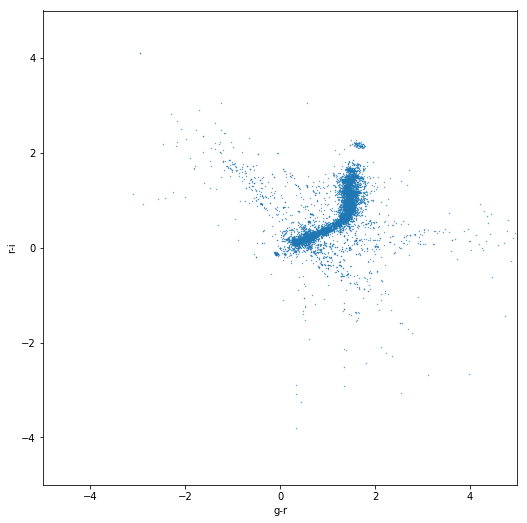

In [67]:
mask = np.where(star_catalog['r'] < 21)
g_r = star_catalog['g'][mask] - star_catalog['r'][mask]
r_i = star_catalog['r'][mask] - star_catalog['i'][mask]

fig, ax = plt.subplots()
fig.set_size_inches(8.5,11)
ax.scatter(g_r, r_i, marker='o', s=0.1)
ax.set_xlabel('g-r')
ax.set_ylabel('r-i')
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)
ax.set_aspect('equal')

In [ ]:
table = XMatch.query(cat1=star_catalog,
                     cat2='vizier:II/246/out',
                     max_distance=10 * u.arcminute, colRA1='ra',
                     colDec1='dec')